# Проект Определение стоимости автомобилей

## Введение


Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.


## Описание данных

### Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
### Целевой признак
- Price — цена (евро)

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.svm import SVC, SVR

matplotlib_axes_logger.setLevel('ERROR')
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('max_colwidth', -1)

sns.set()

## Загрузка данных

In [15]:
df_cars = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
display(df_cars.head(5))
df_cars.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

По загруженным данным можно сделать следующие выводы:
- размерность датасета 354369 х 16
- датасет содержит как числовые так и категориальные типы данных. Кроме полей которые содержат дату и имеют тип object (DateCrawled, DateCreated, LastSeen), все остальные типы соответствуют своим данным. Типы колонок DateCrawled, DateCreated, LastSeen надо перобразовать в соответствующие типы (date или timestamp)
- в некоторых колонках имеются пропуски

## Предобработка данных

- Колонки DateCrawled, DateCreated, LastSeen приведены к типу datetime64
- Остальные колонки типа object приведены к типу string

In [16]:
df_cars_str_col_list = df_cars.select_dtypes(exclude=np.number).columns
df_cars[df_cars_str_col_list] = df_cars[df_cars_str_col_list].astype('string')

df_cars['DateCrawled'] = pd.to_datetime(df_cars['DateCrawled'])
df_cars['DateCreated'] = pd.to_datetime(df_cars['DateCreated'])
df_cars['LastSeen'] = pd.to_datetime(df_cars['LastSeen'])

df_cars.info()
df_cars.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  string        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  string        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  string        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  string        
 10  Brand              354369 non-null  string        
 11  Repaired           283215 non-null  string        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,<NA>,1993,manual,0,golf,150000,0,petrol,volkswagen,<NA>,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,<NA>,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,<NA>,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Колонка NumberOfPictures содержит значения все равные 0. В связи с этим она признана неинформативной и удалена из датасета

In [17]:
df_cars.describe()
df_cars = df_cars.drop(['NumberOfPictures'], axis = 1)
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  string        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  string        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  string        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  string        
 10  Brand              354369 non-null  string        
 11  Repaired           283215 non-null  string        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  PostalCode         354369 non-null  int64   

Для того, чтобы предварительно обнаружить дубликаты, надо определить набор аттрибутов на которых надо определять эти дубликаты. Во первых, надо из общего числа аттрибутов убрать целевой признак Price, потом убрать те входные признаки, которые не будут участвовать в работе модели.
На мой взгляд это такие служебные признаки как:
- DateCrawled — дата скачивания анкеты из базы
- DateCreated — дата создания анкеты
- LastSeen — дата последней активности пользователя

Обнаружено 34565 дубликатов для всех входных аттрибутов (исключая вышеперечисленные). Пока с ними ничего не буду делать, так как далее будет иметь место заполнение пропусков и я посмотрю на дубликаты после этой процедуры.

In [18]:
list_for_duplicates = ["Price", "DateCrawled", "DateCreated", "LastSeen"]
print(f'Количество дубликатов: df_cars: {df_cars.duplicated(subset=df_cars.columns.difference(list_for_duplicates)).sum()}')


Количество дубликатов: df_cars: 34565


Ананлиз данных (метод info()) показал, что пропуски имеют место только в категориальных колонках (кроме колонки Brand) и в связи с этим принято решение заполнить их в пайплайне SimpleImputer модой для соответствующего аттрибута. После этого еще раз провести проверку на дубликаты и уже после этого удалить имеющиеся дубликаты.

In [19]:
cat_col_list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
def display_value_count(df, col_list):
    for c in col_list:
        print(f"------- {c} -------")
        display(df[c].value_counts(dropna = False))

display_value_count(df_cars, cat_col_list)

df_cars.info()

------- VehicleType -------


sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other          3288 
Name: VehicleType, dtype: Int64

------- Gearbox -------


manual    268251
auto      66285 
NaN       19833 
Name: Gearbox, dtype: Int64

------- Model -------


golf                  29232
other                 24421
3er                   19761
NaN                   19705
polo                  13066
                      ...  
i3                    8    
serie_3               4    
rangerover            4    
serie_1               2    
range_rover_evoque    2    
Name: Model, Length: 251, dtype: Int64

------- FuelType -------


petrol      216352
gasoline    98720 
NaN         32895 
lpg         5310  
cng         565   
hybrid      233   
other       204   
electric    90    
Name: FuelType, dtype: Int64

------- Brand -------


volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat              9643 
seat              6907 
mazda             5615 
skoda             5500 
smart             5246 
citroen           5148 
nissan            4941 
toyota            4606 
hyundai           3587 
sonstige_autos    3374 
volvo             3210 
mini              3202 
mitsubishi        3022 
honda             2817 
kia               2465 
suzuki            2323 
alfa_romeo        2314 
chevrolet         1754 
chrysler          1439 
dacia             900  
daihatsu          806  
subaru            762  
porsche           758  
jeep              677  
trabant           589  
land_rover        545  
daewoo            542  
saab              526  
jaguar            505  
rover             486  
lancia            471  
lada              225  
Name: Brand, dtype: Int64

------- Repaired -------


no     247161
NaN    71154 
yes    36054 
Name: Repaired, dtype: Int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  string        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  string        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  string        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  string        
 10  Brand              354369 non-null  string        
 11  Repaired           283215 non-null  string        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  PostalCode         354369 non-null  int64   

Использую пайплайн для применения SimpleImputer на этапе предобработки данных. В пайплайне использую SimpleImputer  для замены NaN на моду для колонок из списка cat_col_list с категориальными признаками так как пропуски имеют место только для этих колонок.


In [20]:

df_cars = df_cars.replace({pd.NA: np.nan})
df_cars_dtypes = df_cars.dtypes

X = df_cars.drop(['Price'], axis=1)
y = df_cars['Price']

simple_imp_pipeline = Pipeline(
    [
        (
            'simpleImputer_nan', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('simple_imp_pipeline', simple_imp_pipeline, X.columns)
    ], 
    remainder='passthrough'
) 

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor)
    ]
)


df_cars_arr = pipe_final.fit_transform(X)
df_cars = pd.concat([pd.DataFrame(df_cars_arr, columns = X.columns),y], axis=1)
for col in df_cars.columns:
  df_cars[col] = df_cars[col].astype(df_cars_dtypes[col])
display_value_count(df_cars, cat_col_list)
df_cars.info()

------- VehicleType -------


sedan          128947
small          79831 
wagon          65166 
bus            28775 
convertible    20203 
coupe          16163 
suv            11996 
other          3288  
Name: VehicleType, dtype: int64

------- Gearbox -------


manual    288084
auto      66285 
Name: Gearbox, dtype: int64

------- Model -------


golf                  48937
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2               8    
serie_3               4    
rangerover            4    
serie_1               2    
range_rover_evoque    2    
Name: Model, Length: 250, dtype: int64

------- FuelType -------


petrol      249247
gasoline    98720 
lpg         5310  
cng         565   
hybrid      233   
other       204   
electric    90    
Name: FuelType, dtype: int64

------- Brand -------


volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat              9643 
seat              6907 
mazda             5615 
skoda             5500 
smart             5246 
citroen           5148 
nissan            4941 
toyota            4606 
hyundai           3587 
sonstige_autos    3374 
volvo             3210 
mini              3202 
mitsubishi        3022 
honda             2817 
kia               2465 
suzuki            2323 
alfa_romeo        2314 
chevrolet         1754 
chrysler          1439 
dacia             900  
daihatsu          806  
subaru            762  
porsche           758  
jeep              677  
trabant           589  
land_rover        545  
daewoo            542  
saab              526  
jaguar            505  
rover             486  
lancia            471  
lada              225  
Name: Brand, dtype: Int64

------- Repaired -------


no     318315
yes    36054 
Name: Repaired, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   VehicleType        354369 non-null  object        
 2   RegistrationYear   354369 non-null  int64         
 3   Gearbox            354369 non-null  object        
 4   Power              354369 non-null  int64         
 5   Model              354369 non-null  object        
 6   Kilometer          354369 non-null  int64         
 7   RegistrationMonth  354369 non-null  int64         
 8   FuelType           354369 non-null  object        
 9   Brand              354369 non-null  string        
 10  Repaired           354369 non-null  object        
 11  DateCreated        354369 non-null  datetime64[ns]
 12  PostalCode         354369 non-null  int64         
 13  LastSeen           354369 non-null  datetime

После замены пропусков на моду еще раз проверил количество дубликатов и их число теперь увеличилось и равно 40351. Удаляю эти дубликаты. Если позже придется в рамках исправления возможных аномалий и выбросов заменять их на какие либо значения для определенных колонок - то процедуру проверки и удаления дубликатов на этом же множестве аттрибутов надо повторить.

In [21]:
print(f'Количество дубликатов: df_cars: {df_cars.duplicated(subset=df_cars.columns.difference(list_for_duplicates)).sum()}')
df_cars = df_cars.drop_duplicates(subset=df_cars.columns.difference(list_for_duplicates))
print(f'Количество дубликатов: df_cars: {df_cars.duplicated(subset=df_cars.columns.difference(list_for_duplicates)).sum()}')

Количество дубликатов: df_cars: 40351
Количество дубликатов: df_cars: 0


In [22]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314018 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        314018 non-null  datetime64[ns]
 1   VehicleType        314018 non-null  object        
 2   RegistrationYear   314018 non-null  int64         
 3   Gearbox            314018 non-null  object        
 4   Power              314018 non-null  int64         
 5   Model              314018 non-null  object        
 6   Kilometer          314018 non-null  int64         
 7   RegistrationMonth  314018 non-null  int64         
 8   FuelType           314018 non-null  object        
 9   Brand              314018 non-null  string        
 10  Repaired           314018 non-null  object        
 11  DateCreated        314018 non-null  datetime64[ns]
 12  PostalCode         314018 non-null  int64         
 13  LastSeen           314018 non-null  datetime

## Исследовательский анализ данных

In [23]:
def plot_sub_plot_hist_boxplot(df, col_list, title):
    for col in col_list:
        if col == 'id':
            continue
        fig, axes = plt.subplots(nrows=1, ncols=2)
        df[col].plot(kind="hist", title=col, figsize=(10, 5), ax = axes[0])
        sns.boxplot(df[col], ax = axes[1])
        plt.title(title)
        plt.show()

def plot_pie_plot_for_columns(df, col_list, title):
    for col in col_list:
        df[col].value_counts().plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, figsize=(5,5), title=col);
        plt.title(f'{title} for {col}')
        plt.show()

def plot_bar_plot_for_columns(df, col_list, title, normalizer = 1):
    for col in col_list:
        print(col)
        ax = df[col].value_counts().plot(kind='bar',  label='',  figsize=(5,5), title=col);
        plt.title(f'{title} for {col}')
        if normalizer != 1:
          vals = ax.get_yticks()
          ax.set_yticklabels(['{:,.0%}'.format(x / normalizer) for x in vals])
        plt.show()

Для начала посмотрим на значения колонок с timestamps и RegistrationYear - как они сочетаются друг с другом

Из анализа графиков и вывода метода describe() для колонок *'DateCrawled', 'DateCreated', 'LastSeen'* видно, что данные по этим трем колонкам в основном сосредоточены в диапазоне 2016-01 - 2016-04. Выше правой границы значений нет, ниже левой границы есть небольшое количество выбросов до 2014-04

Проанализировав график и вывода метода decribe() атрибуту RegistrationYear - видно что его среднее и медиана находятся в районе 2003-2004 гг, но имеют место выбросы как в большую сторону вплоть до 9999, так и в меньшую сторону вплоть до 1000. Так как нет возможности выяснить как собирались эти данные и выяснить причину этих выбросов - то необходимо сначала избавиться от слишком явных выбросов - так как я не вижу тут больше других вариантов как и чем их можно было заменить. Так как max Значение аттрибута *DateCreated*  = 2016-04-07 то наибольшее валидное значение аттрибута RegistrationYear это 2016 г так как при создании анкеты нельзя указать автомобиль с годом регистрации в будущем (если это не ошибка ввода). Таким образом верхняя граница отсечки по аттрибуту RegistrationYear это 2016. Что касается нижней границы отсечки то возьмем ее условно равной 1950 годом - автомобили за более ранние даты от 1950 г до момента начала автомобильной эры (1900 г) представляют собой уже очень дорогие раритеты, ну а за период от 1000 до 1900 гг никаких автомобилей не было. В данном допущении я исхожу из того, что аттрибут RegistrationYear важен для работы модели, так как он на мой взгляд, является признаком, по которому можно охарактеризовать тот или иной автомобиль и мы не можем просто исключить его из входных признаков для модели.

,DateCrawled,DateCreated,LastSeen
count,314018,314018,314018
unique,247447,109,160534
top,2016-03-24 14:49:47,2016-04-03 00:00:00,2016-04-06 12:15:45
freq,7,12364,16
first,2016-03-05 14:06:24,2014-03-10 00:00:00,2016-03-05 14:15:08
last,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


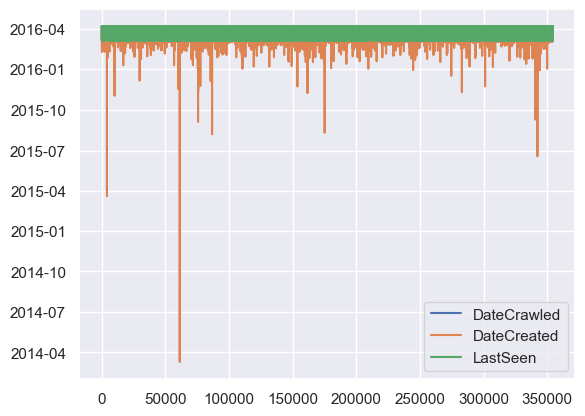

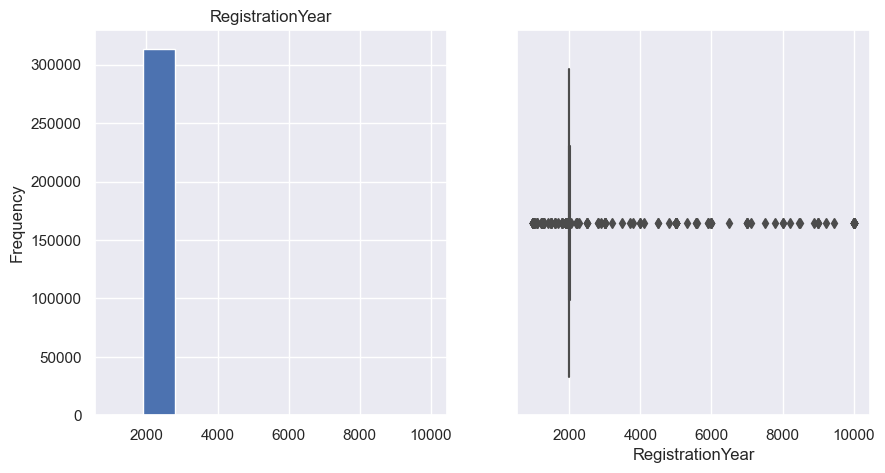

,RegistrationYear
count,314018.000000
mean,2004.183935
std,90.665822
min,1000.000000
25%,1999.000000
50%,2003.000000
75%,2008.000000
max,9999.000000


In [24]:
df_cars.loc[:,['DateCrawled', 'DateCreated', 'LastSeen']].plot.line();
display(df_cars.loc[:,['DateCrawled', 'DateCreated', 'LastSeen']].describe())
plot_sub_plot_hist_boxplot(df_cars, ['RegistrationYear'],'')
display(df_cars.loc[:,['RegistrationYear']].describe())

После отсечки гистограмма RegistrationYear приобрела боллее читаемый вид, графики для аттрибутов 'DateCrawled', 'DateCreated', 'LastSeen' особо не изменились. Далее нужно провести проверку на соответствие даты из аттрибутов DateCreated и RegistrationYear, при этом DateCreated приведенный к году должен быть больше или равен RegistrationYear, другими словами нельзя при создании анкеты указать RegistrationYear в будущем.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300569 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        300569 non-null  datetime64[ns]
 1   VehicleType        300569 non-null  object        
 2   RegistrationYear   300569 non-null  int64         
 3   Gearbox            300569 non-null  object        
 4   Power              300569 non-null  int64         
 5   Model              300569 non-null  object        
 6   Kilometer          300569 non-null  int64         
 7   RegistrationMonth  300569 non-null  int64         
 8   FuelType           300569 non-null  object        
 9   Brand              300569 non-null  string        
 10  Repaired           300569 non-null  object        
 11  DateCreated        300569 non-null  datetime64[ns]
 12  PostalCode         300569 non-null  int64         
 13  LastSeen           300569 non-null  datetime

,DateCrawled,DateCreated,LastSeen
count,300569,300569,300569
unique,239378,108,154832
top,2016-03-24 14:49:47,2016-04-03 00:00:00,2016-04-07 13:17:48
freq,7,11858,16
first,2016-03-05 14:06:24,2014-03-10 00:00:00,2016-03-05 14:15:08
last,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


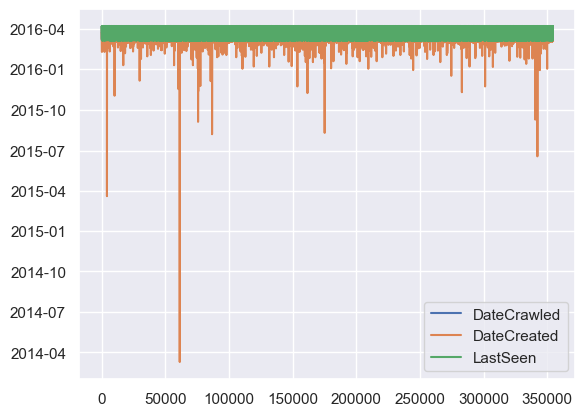

In [25]:
df_cars_ryear_cut = df_cars[(df_cars['RegistrationYear'] <= 2016) & (df_cars['RegistrationYear'] >= 1950)]
df_cars_ryear_cut.info()
df_cars_ryear_cut.loc[:,['DateCrawled', 'DateCreated', 'LastSeen']].plot.line();
display(df_cars_ryear_cut.loc[:,['DateCrawled', 'DateCreated', 'LastSeen']].describe())

Тут я вижу, что записей для которых не выполняется указанное выше условие в датафрейме нет - то есть даты  DateCreated и RegistrationYear согласованы

In [26]:
df_cars_ryear_cut['CreatedYear'] = df_cars_ryear_cut['DateCreated'].dt.strftime('%Y')
df_cars_ryear_cut['CreatedYear'] = df_cars_ryear_cut['CreatedYear'].astype('int64')
print(df_cars_ryear_cut['Brand'].count())
df_cars_ryear_cut_new = df_cars_ryear_cut[df_cars_ryear_cut['CreatedYear'] >= df_cars_ryear_cut['RegistrationYear']]
print(df_cars_ryear_cut_new['Brand'].count())

300569
300569


/var/folders/f_/cl238sk96cjc68_lpl98ybgw0000gn/T/ipykernel_92261/132408727.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cars_ryear_cut['CreatedYear'] = df_cars_ryear_cut['DateCreated'].dt.strftime('%Y')
/var/folders/f_/cl238sk96cjc68_lpl98ybgw0000gn/T/ipykernel_92261/132408727.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cars_ryear_cut['CreatedYear'] = df_cars_ryear_cut['CreatedYear'].astype('int64')


In [27]:
df_cars_ryear_cut = df_cars_ryear_cut.drop(['CreatedYear'], axis=1)
df_cars_ryear_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300569 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        300569 non-null  datetime64[ns]
 1   VehicleType        300569 non-null  object        
 2   RegistrationYear   300569 non-null  int64         
 3   Gearbox            300569 non-null  object        
 4   Power              300569 non-null  int64         
 5   Model              300569 non-null  object        
 6   Kilometer          300569 non-null  int64         
 7   RegistrationMonth  300569 non-null  int64         
 8   FuelType           300569 non-null  object        
 9   Brand              300569 non-null  string        
 10  Repaired           300569 non-null  object        
 11  DateCreated        300569 non-null  datetime64[ns]
 12  PostalCode         300569 non-null  int64         
 13  LastSeen           300569 non-null  datetime

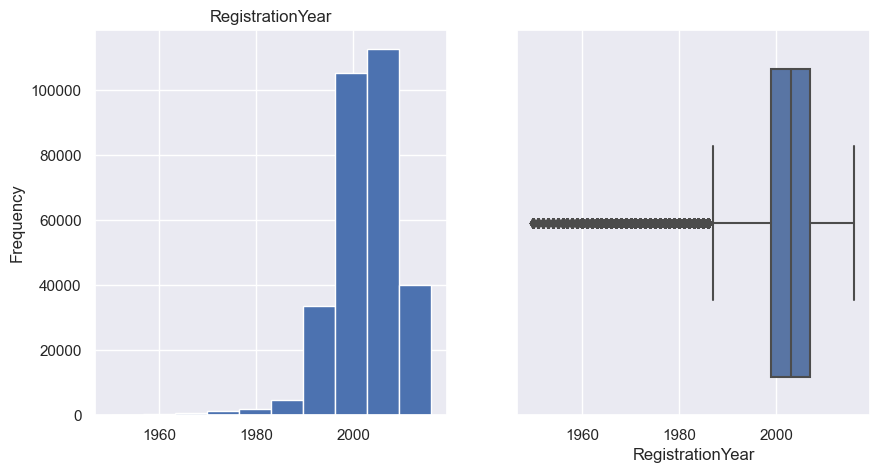

,RegistrationYear
count,300569.000000
mean,2002.446872
std,6.938305
min,1950.000000
25%,1999.000000
50%,2003.000000
75%,2007.000000
max,2016.000000


In [28]:
plot_sub_plot_hist_boxplot(df_cars_ryear_cut, ['RegistrationYear'],'')
display(df_cars_ryear_cut.loc[:,['RegistrationYear']].describe())

Поменял тип для аттрибутов с object на string. PostalCode и RegistrationMonth также сделал категориальными переменными

In [29]:
int_to_string_col_list = ['RegistrationMonth', 'PostalCode', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
#df_cars.info()
df_cars_ryear_cut[int_to_string_col_list] = df_cars_ryear_cut[int_to_string_col_list].astype('string')
df_cars_ryear_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300569 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        300569 non-null  datetime64[ns]
 1   VehicleType        300569 non-null  string        
 2   RegistrationYear   300569 non-null  int64         
 3   Gearbox            300569 non-null  string        
 4   Power              300569 non-null  int64         
 5   Model              300569 non-null  string        
 6   Kilometer          300569 non-null  int64         
 7   RegistrationMonth  300569 non-null  string        
 8   FuelType           300569 non-null  string        
 9   Brand              300569 non-null  string        
 10  Repaired           300569 non-null  string        
 11  DateCreated        300569 non-null  datetime64[ns]
 12  PostalCode         300569 non-null  string        
 13  LastSeen           300569 non-null  datetime

Далее я вывожу статситику по категориальным признакам - 'VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired', 'PostalCode' - такие методы как describe, value_counts и bar plot (в bar plot не включил PostalCode так как там очень большое количество уникальных значений и график неинформативен и очень долго строится). Статистика по RegistrationMonth показывает что этот аттрибут принимает значения от 0 до 12 включительно то есть 13 различных значений - а месяцев в году 12. При этом частота повторения каждого месяца примерно одинакова и в связи с этим непонятно как быть с лишним месяцем - то ли брать за начальное значение 0 и тогда лишним будет месяц 12, то ли отсчет вести от месяца 1 и тогда лишним будет месяц 0 и также непонятно что делать с этим лишним месяцем - заменять его на моду множества - так частота примерно одинакова. Отбросить данные с "лишним" месяцем тоже нельзя - так как непонятно какой месяц считать лишним. Поскольку у меня нет информации с чем связана подобная ошибка ввода и как ее надо исправлять - я предлагаю оставить эту ситуаци как есть и ничего с ней не делать. В связи с чем в предсказании модели по аттрибуту Month будет заложена некая погрешность - можно в будущем попробовать удалить этот аттрибут и посмореть как это оразится на метрике.

,VehicleType,Gearbox,Model,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
count,300569,300569,300569,300569,300569,300569,300569,300569
unique,8,2,250,13,7,40,2,8138
top,sedan,manual,golf,0,petrol,volkswagen,no,65428
freq,101576,243941,40556,30802,210411,64402,268218,480


sedan          101576
small          70014 
wagon          57070 
bus            25762 
convertible    17991 
coupe          14470 
suv            10587 
other          3099  
Name: VehicleType, dtype: Int64

manual    243941
auto      56628 
Name: Gearbox, dtype: Int64

golf                  40556
other                 21964
3er                   16823
polo                  11001
corsa                 10354
                      ...  
kalina                5    
serie_3               4    
rangerover            3    
serie_1               2    
range_rover_evoque    1    
Name: Model, Length: 250, dtype: Int64

0     30802
3     29291
6     26857
4     25157
5     24899
7     23398
10    22027
11    20445
12    20356
9     20297
1     19745
8     19248
2     18047
Name: RegistrationMonth, dtype: Int64

petrol      210411
gasoline    84641 
lpg         4538  
cng         488   
hybrid      216   
other       187   
electric    88    
Name: FuelType, dtype: Int64

volkswagen        64402
opel              33382
bmw               31350
mercedes_benz     27546
audi              25180
ford              21365
renault           15024
peugeot           9285 
fiat              8138 
seat              5733 
mazda             4831 
skoda             4674 
smart             4553 
citroen           4439 
nissan            4227 
toyota            4072 
hyundai           3071 
sonstige_autos    2938 
volvo             2788 
mini              2729 
mitsubishi        2625 
honda             2442 
kia               2093 
suzuki            2017 
alfa_romeo        2007 
chevrolet         1532 
chrysler          1278 
dacia             769  
daihatsu          691  
porsche           687  
subaru            686  
jeep              597  
trabant           532  
land_rover        489  
saab              465  
daewoo            457  
jaguar            448  
rover             414  
lancia            413  
lada              200  
Name: Brand, dtype: Int64

no     268218
yes    32351 
Name: Repaired, dtype: Int64

65428    480
66333    267
78224    263
32257    261
52525    252
        ... 
17154    1  
91465    1  
79595    1  
31088    1  
44239    1  
Name: PostalCode, Length: 8138, dtype: Int64

VehicleType


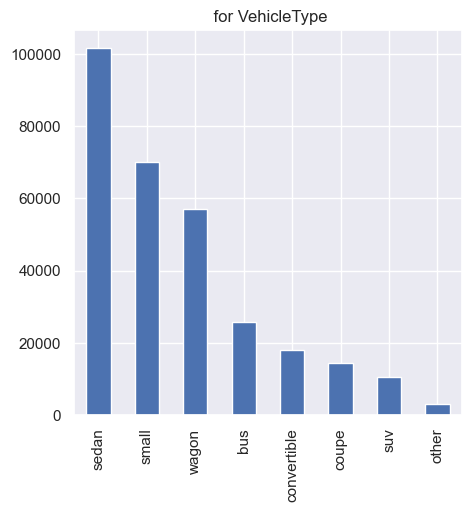

Gearbox


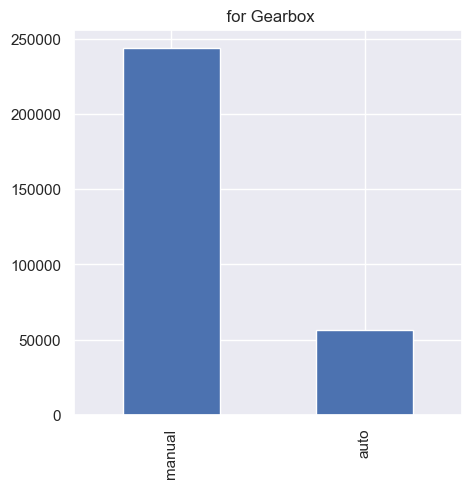

Model


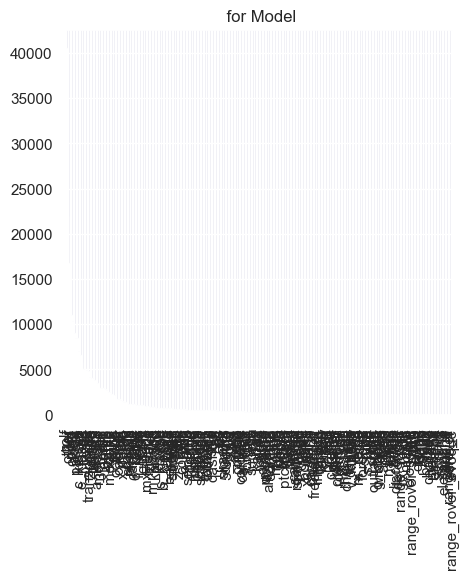

RegistrationMonth


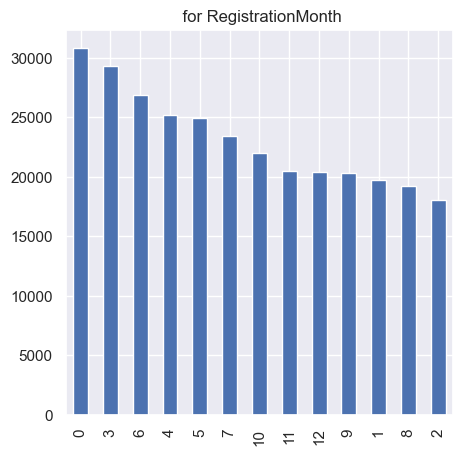

FuelType


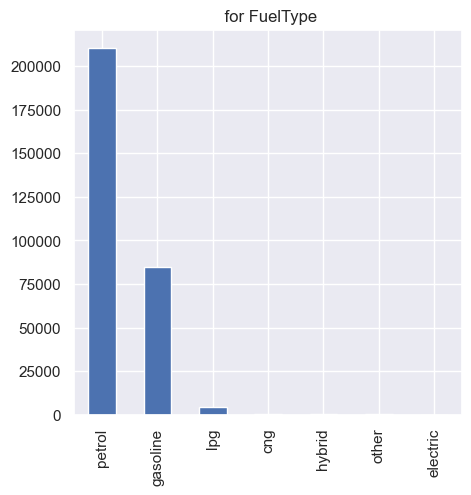

Brand


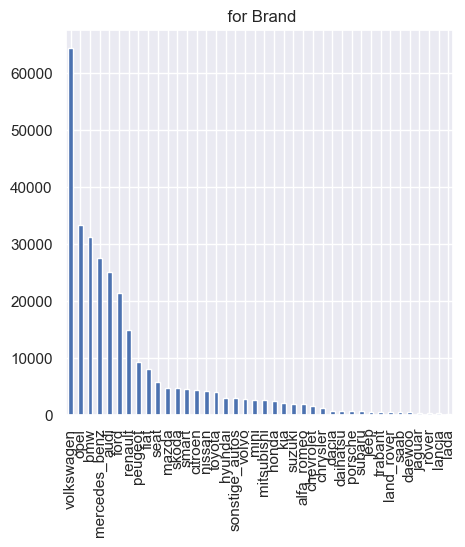

Repaired


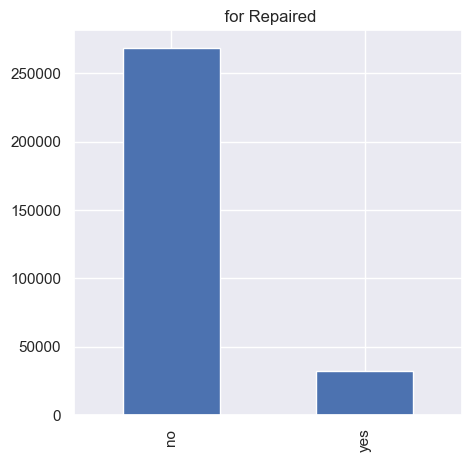

In [30]:
cat_list = ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired', 'PostalCode']
display(df_cars_ryear_cut.loc[:,cat_list].describe())
for c in cat_list:
    display(df_cars_ryear_cut[c].value_counts())

plot_bar_plot_for_columns(df_cars_ryear_cut, ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired'], "")

Анализ гистограмм числовых аттрибутов 'Power', 'Kilometer' показал, что:
- аттрибут Power варьируется в диапазоне от 0 до 20000 л.c. Величина 0 это очевидно ошибочное значение (и ряд значений от 0 до некоего минимального 50 л.c. также ошибочны), но и  значения свыше 1000 л.c. также являются ошибочными - 1000 л.c. это мощность гоночного болида. Поэтому я предлагаю сделать отсечку по этому аттрибуту по диапазону 50; 1000 так как я не знаю как вводились эти данные и с чем может связана такая ошибка
- аттрибут Kilometer принимает min и max значения равными 5000 и 150000 что кажется мне вполне валидными значениями для пробега

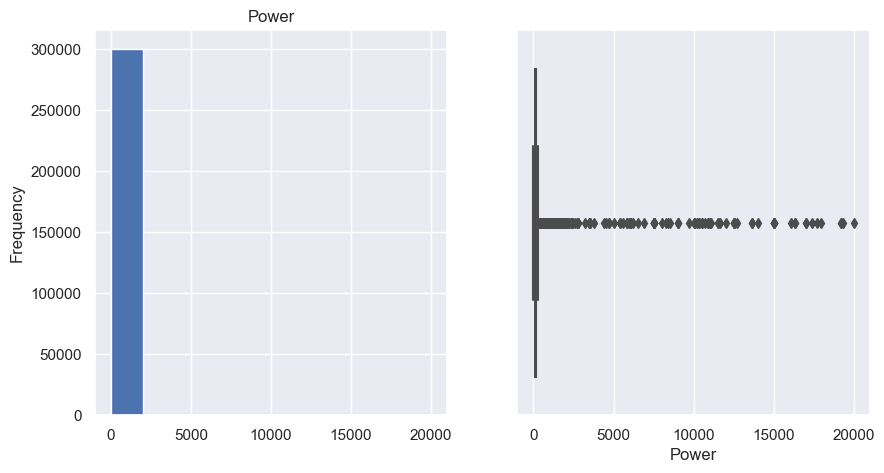

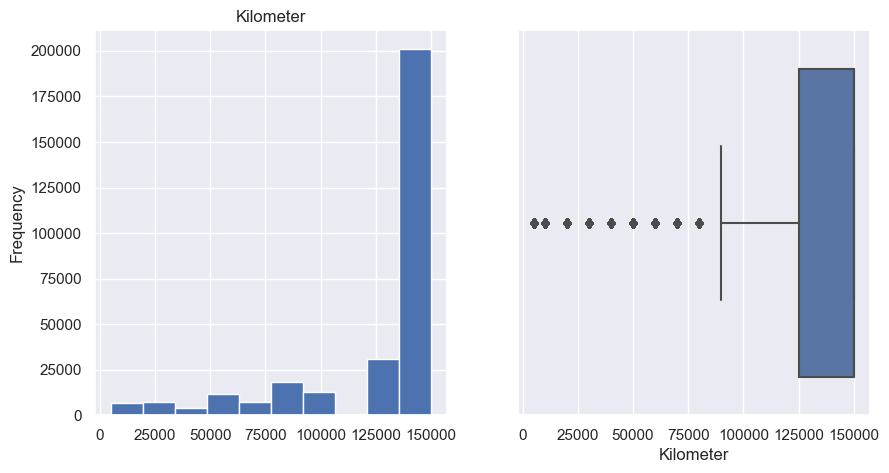

,Power,Kilometer
count,300569.000000,300569.000000
mean,110.789389,127999.311306
std,196.500722,38039.817259
min,0.000000,5000.000000
25%,69.000000,125000.000000
50%,105.000000,150000.000000
75%,143.000000,150000.000000
max,20000.000000,150000.000000


In [31]:
num_list = ['Power', 'Kilometer']
plot_sub_plot_hist_boxplot(df_cars_ryear_cut, num_list, '')
display(df_cars_ryear_cut.loc[:,num_list].describe())

Графики для Power после обрезки

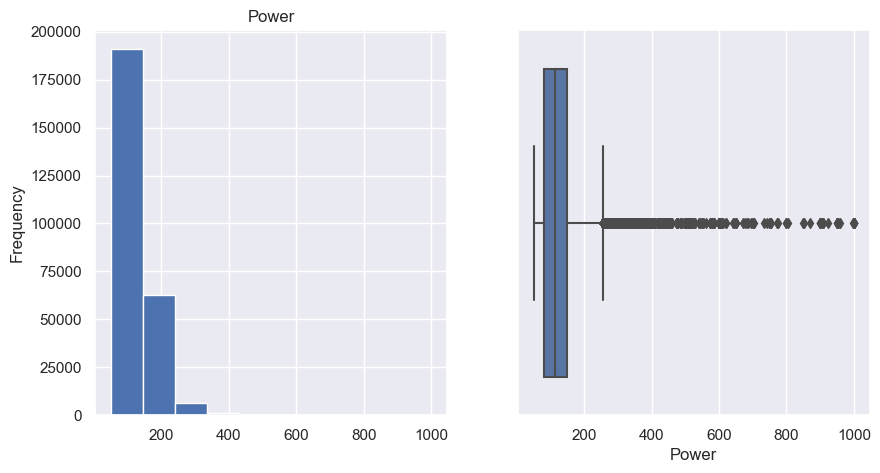

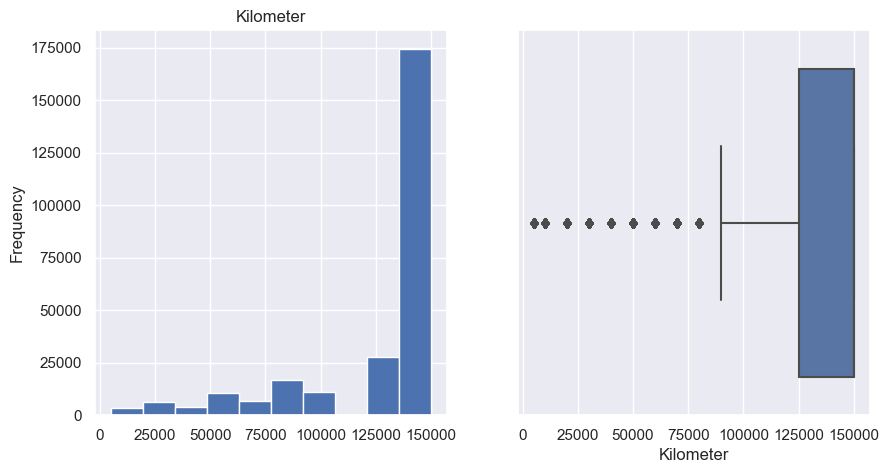

,Power,Kilometer
count,261506.000000,261506.000000
mean,122.205697,128534.966693
std,54.453401,36721.431135
min,50.000000,5000.000000
25%,80.000000,125000.000000
50%,114.000000,150000.000000
75%,150.000000,150000.000000
max,1000.000000,150000.000000


In [32]:
df_cars_ryear_cut_power = df_cars_ryear_cut[(df_cars_ryear_cut['Power'] <= 1000) & (df_cars_ryear_cut['Power'] >= 50)]
plot_sub_plot_hist_boxplot(df_cars_ryear_cut_power, num_list, '')
display(df_cars_ryear_cut_power.loc[:,num_list].describe())

Scatter pair plot для числовых аттрибутов 'RegistrationYear', 'Kilometer', 'Power' не показал каких либо аномалий

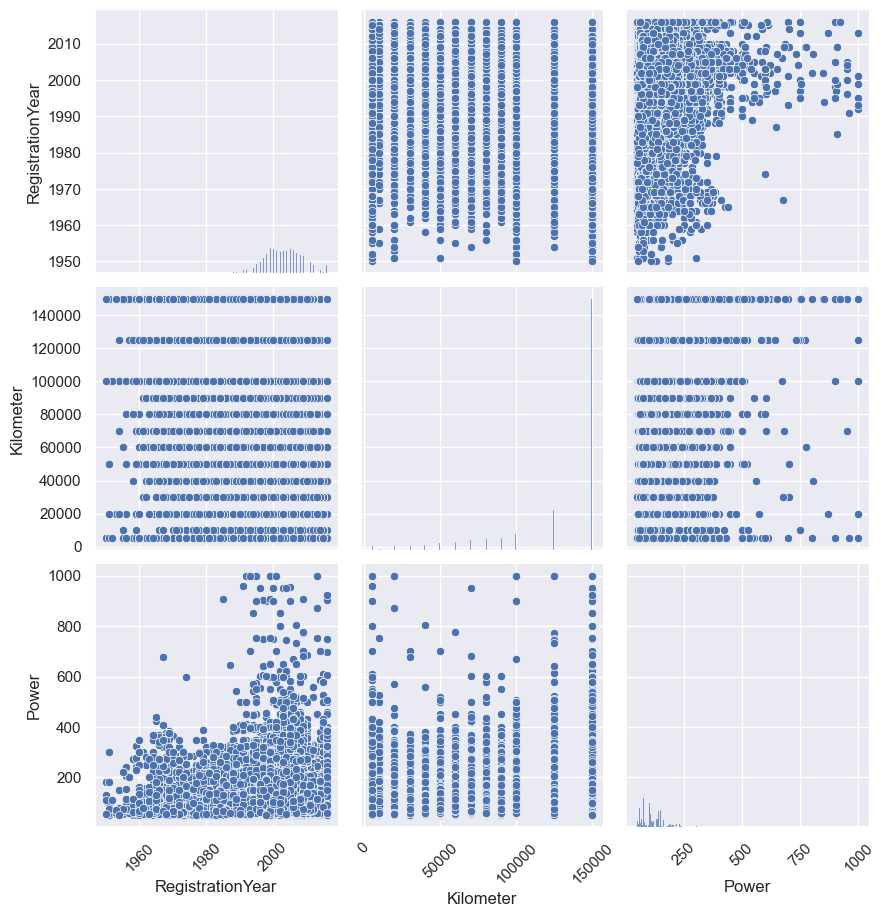

In [33]:
scatter_col_list = ['RegistrationYear', 'Kilometer', 'Power']
g = sns.pairplot(data = df_cars_ryear_cut_power, vars = scatter_col_list, height=3)
for ax in g.axes.flat:
    ax.tick_params("x", labelrotation=45)

Убираю из датафрейма df_cars_ryear_cut_power колонки 'DateCrawled', 'DateCreated', 'LastSeen' которые не нужны для моделирования так как представляют собой справочную информацию

In [34]:
df_cars_ryear_cut_power = df_cars_ryear_cut_power.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
df_cars_ryear_cut_power.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261506 entries, 1 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VehicleType        261506 non-null  string
 1   RegistrationYear   261506 non-null  int64 
 2   Gearbox            261506 non-null  string
 3   Power              261506 non-null  int64 
 4   Model              261506 non-null  string
 5   Kilometer          261506 non-null  int64 
 6   RegistrationMonth  261506 non-null  string
 7   FuelType           261506 non-null  string
 8   Brand              261506 non-null  string
 9   Repaired           261506 non-null  string
 10  PostalCode         261506 non-null  string
 11  Price              261506 non-null  int64 
dtypes: int64(4), string(8)
memory usage: 25.9 MB


Фик матрица была построена по всем аттрибутам датафрейма df_cars_ryear_cut_power за вычетом целевого аттрибута Price. Из анализа этой матрицы я вижу:
- корреляция между аттрибутами Model и Brand = 1. Это объяснимо так как Модель в данном случае является Брендом и наоборот - между ними взаимно однозначное соответствие (возможно отношение один ко многим для связи Brand -> Model)
- корреляция между Model и VehicleType довольно высока = 0.91
- корреляция между Brand и VehicleType ниже и = 0.62

В связи с этим предлагается убрать из входных аттрибутов Model так как он имеет высокую корреляцию с двуми другими аттрибутами Brand и VehicleType

/Users/Theo/miniconda3/envs/yap/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable PostalCode is large: 8118. Are you sure this is not an interval variable? Analysis for pairs of variables including PostalCode can be slow.
  warnings.warn(
/Users/Theo/miniconda3/envs/yap/lib/python3.9/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 2021382. Are interval variables set correctly?
  warnings.warn(


,Brand,FuelType,Gearbox,Kilometer,Model,PostalCode,Power,RegistrationMonth,RegistrationYear,Repaired,VehicleType
Brand,1.000000,0.278465,0.498033,0.269652,0.997582,0.528516,0.492810,0.084210,0.346011,0.083186,0.623438
FuelType,0.278465,1.000000,0.142018,0.138243,0.520260,0.180510,0.147257,0.085399,0.256646,0.034273,0.318182
Gearbox,0.498033,0.142018,1.000000,0.027377,0.610460,0.179673,0.540583,0.053426,0.119628,0.030874,0.277047
Kilometer,0.269652,0.138243,0.027377,1.000000,0.442470,0.215858,0.075090,0.071775,0.384839,0.091775,0.179285
Model,0.997582,0.520260,0.610460,0.442470,1.000000,0.773260,0.640127,0.161234,0.592710,0.123823,0.907068
PostalCode,0.528516,0.180510,0.179673,0.215858,0.773260,1.000000,0.185060,0.222069,0.306175,0.115973,0.231729
Power,0.492810,0.147257,0.540583,0.075090,0.640127,0.185060,1.000000,0.032772,0.153979,0.048593,0.288583
RegistrationMonth,0.084210,0.085399,0.053426,0.071775,0.161234,0.222069,0.032772,1.000000,0.117553,0.066257,0.088972
RegistrationYear,0.346011,0.256646,0.119628,0.384839,0.592710,0.306175,0.153979,0.117553,1.000000,0.149122,0.187325
Repaired,0.083186,0.034273,0.030874,0.091775,0.123823,0.115973,0.048593,0.066257,0.149122,1.000000,0.061777


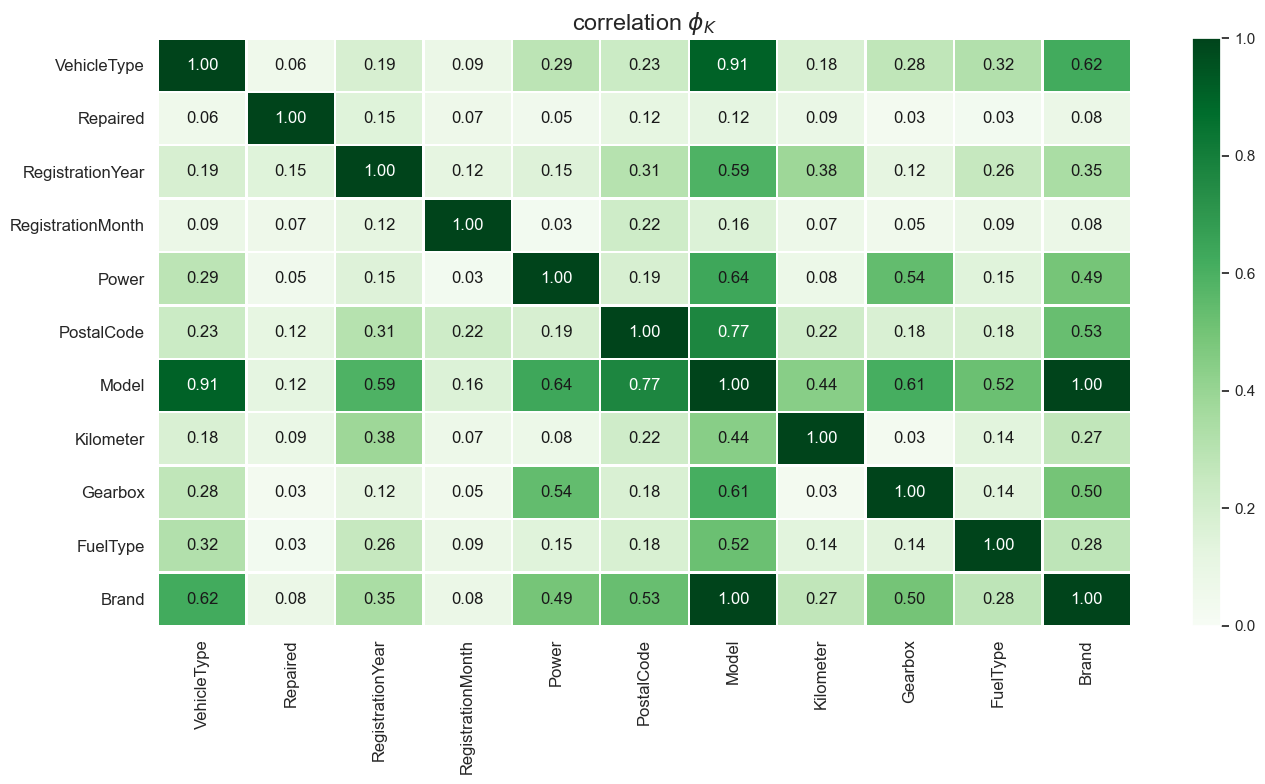

In [35]:
phik_overview = phik_matrix(df_cars_ryear_cut_power[df_cars_ryear_cut_power.columns.difference(['Price'])], interval_cols=scatter_col_list)

display(phik_overview)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.2,
    figsize=(14, 8)
)

In [36]:
df_cars_ryear_cut_power = df_cars_ryear_cut_power.drop(['Model'], axis=1)
df_cars_ryear_cut_power.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261506 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VehicleType        261506 non-null  string
 1   RegistrationYear   261506 non-null  int64 
 2   Gearbox            261506 non-null  string
 3   Power              261506 non-null  int64 
 4   Kilometer          261506 non-null  int64 
 5   RegistrationMonth  261506 non-null  string
 6   FuelType           261506 non-null  string
 7   Brand              261506 non-null  string
 8   Repaired           261506 non-null  string
 9   PostalCode         261506 non-null  string
 10  Price              261506 non-null  int64 
dtypes: int64(4), string(7)
memory usage: 23.9 MB


После удаления аттрибута Model фик матрица выглядит лучше.

/Users/Theo/miniconda3/envs/yap/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable PostalCode is large: 8118. Are you sure this is not an interval variable? Analysis for pairs of variables including PostalCode can be slow.
  warnings.warn(


,Brand,FuelType,Gearbox,Kilometer,PostalCode,Power,RegistrationMonth,RegistrationYear,Repaired,VehicleType
Brand,1.000000,0.278465,0.498033,0.269652,0.528516,0.492810,0.084210,0.346011,0.083186,0.623438
FuelType,0.278465,1.000000,0.142018,0.138243,0.180510,0.147257,0.085399,0.256646,0.034273,0.318182
Gearbox,0.498033,0.142018,1.000000,0.027377,0.179673,0.540583,0.053426,0.119628,0.030874,0.277047
Kilometer,0.269652,0.138243,0.027377,1.000000,0.215858,0.075090,0.071775,0.384839,0.091775,0.179285
PostalCode,0.528516,0.180510,0.179673,0.215858,1.000000,0.185060,0.222069,0.306175,0.115973,0.231729
Power,0.492810,0.147257,0.540583,0.075090,0.185060,1.000000,0.032772,0.153979,0.048593,0.288583
RegistrationMonth,0.084210,0.085399,0.053426,0.071775,0.222069,0.032772,1.000000,0.117553,0.066257,0.088972
RegistrationYear,0.346011,0.256646,0.119628,0.384839,0.306175,0.153979,0.117553,1.000000,0.149122,0.187325
Repaired,0.083186,0.034273,0.030874,0.091775,0.115973,0.048593,0.066257,0.149122,1.000000,0.061777
VehicleType,0.623438,0.318182,0.277047,0.179285,0.231729,0.288583,0.088972,0.187325,0.061777,1.000000


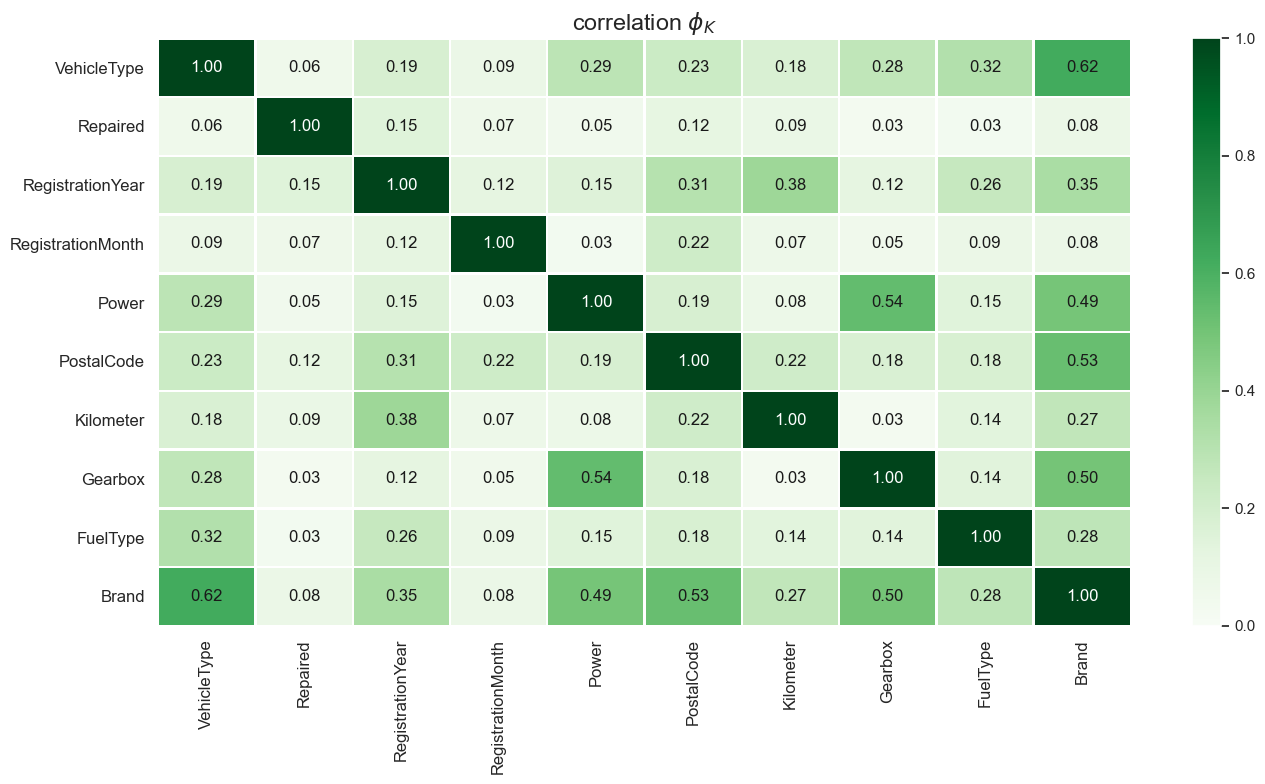

In [37]:
phik_overview = phik_matrix(df_cars_ryear_cut_power[df_cars_ryear_cut_power.columns.difference(['Price'])], interval_cols=scatter_col_list)

display(phik_overview)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.2,
    figsize=(14, 8)
)